[Think Stats Chapter 7 Exercise 1](http://greenteapress.com/thinkstats2/html/thinkstats2008.html#toc70) (weight vs. age)

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

This notebook has been converted to a markdown file using [convert_notebooks_to_markdown.py](./convert_notebooks_to_markdown.py).


# Answer

In [12]:
print('The values determined for Pearson\'s and Spearman\'s correlation ({:.3f} and {:.3f}, respectively) indicate birth weight and mother\'s age are weakly correlated. The difference between these two values also indicates some non-linearity in the data.'.format(pearson_r, spearman_r))

The values determined for Pearson's and Spearman's correlation (0.069 and 0.095, respectively) indicate birth weight and mother's age are weakly correlated. The difference between these two values also indicates some non-linearity in the data.


The scatter and quantile plots support the conclusion that that age and birth weight are not strongly correlated. Note that I binned the data every 2.5 years whereas the answers provided with the book binned the data every 3 years. This likely explains slight variations in the quantiles.

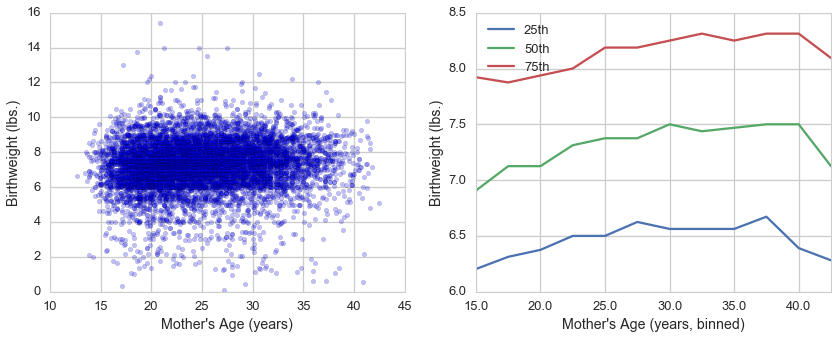

In [13]:
plt.show()

# Code

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from load_ThinkStats import load_FemPreg

%matplotlib inline
%config InlineBackend.close_figures = False

## Clean and bin the data

Part of the cleaning process involves selecting only live births. This uses a custom library I wrote called [`load_ThinkStats`](load_ThinkStats.py).

In [2]:
df = load_FemPreg(True)

df = df.loc[df.outcome == 1]
assert df.shape[0] == 9148
assert (df.outcome==1).all() == True

df = df[['agepreg', 'totalwgt_lb']].dropna().sort_values('totalwgt_lb')

The data are binned in 2.5 year increments. To follow the same convention as is used in the book, bins are assigned based on the highest year of the bin.

In [3]:
print(df.agepreg.min(), df.agepreg.max())

10.83 44.08


In [4]:
ages = np.arange(10.0, 47.5, 2.5)
df['age_bin'] = pd.cut(df.agepreg, ages, labels=ages[1:], right=True)

age_groups = (df.age_bin
              .value_counts()
              .to_frame()
              .sort_index()
              .rename(columns={'age_bin':'frequency'}))

In [5]:
print(tabulate(age_groups,
               headers=['frequency'],
               tablefmt='pipe')
      )

|      |   frequency |
|-----:|------------:|
| 12.5 |           3 |
| 15   |          62 |
| 17.5 |         574 |
| 20   |        1330 |
| 22.5 |        1525 |
| 25   |        1411 |
| 27.5 |        1268 |
| 30   |        1071 |
| 32.5 |         860 |
| 35   |         506 |
| 37.5 |         280 |
| 40   |         114 |
| 42.5 |          31 |
| 45   |           3 |


The lowest and highest age groups (12.5 and 45, respectively) are quite small and should probably be excluded from the analysis.

In [6]:
mask = df.age_bin.isin(age_groups.query('frequency > 3').index)

num_rows = df.shape[0]
df = df.loc[mask]

df['age_bin'] = df.age_bin.cat.remove_unused_categories()

assert df.shape[0] == num_rows-6

## Determine statistical features of the data
Calculate Pearson's and Spearman's correlation.

Pearson's Correlation (R) is:
$$\rho = \frac{Cov(X,Y)}{S_X S_Y}$$

The equation for Spearman's Correlation (R) is similar but variables are converted to their ranked values [1,2,3,4...] within their respective series. Because ranked values are used, Spearman's R tends to be more robust if there are outliers.

In [7]:
pearson_r = stats.pearsonr(df.agepreg, df.totalwgt_lb)[0]

spearman_r = stats.spearmanr(df.agepreg, df.totalwgt_lb).correlation

print('Pearson\'s R is {:.3f} and Spearman\'s R is {:.3f}'.format(pearson_r, spearman_r))

Pearson's R is 0.069 and Spearman's R is 0.095


Calculate the birthweight percentile for each age, as binned in 2.5 year increments.

In [8]:
def get_quantiles(df):
    return pd.DataFrame({'size':df.shape[0], 
                         '25th':df.quantile(0.25), 
                         '50th':df.quantile(0.50), 
                         '75th':df.quantile(0.75)})

quantiles = ( df[['age_bin','totalwgt_lb']]
             .groupby('age_bin')
             .apply(get_quantiles)
             .reset_index(level=-1, drop=True)
            )

In [11]:
print(tabulate(quantiles,
               headers=quantiles.columns.tolist(),
               tablefmt='pipe')
     )

|      |    25th |    50th |    75th |   size |
|-----:|--------:|--------:|--------:|-------:|
| 15   | 6.20312 | 6.90625 | 7.92188 |     62 |
| 17.5 | 6.3125  | 7.125   | 7.875   |    574 |
| 20   | 6.375   | 7.125   | 7.9375  |   1330 |
| 22.5 | 6.5     | 7.3125  | 8       |   1525 |
| 25   | 6.5     | 7.375   | 8.1875  |   1411 |
| 27.5 | 6.625   | 7.375   | 8.1875  |   1268 |
| 30   | 6.5625  | 7.5     | 8.25    |   1071 |
| 32.5 | 6.5625  | 7.4375  | 8.3125  |    860 |
| 35   | 6.5625  | 7.46875 | 8.25    |    506 |
| 37.5 | 6.67188 | 7.5     | 8.3125  |    280 |
| 40   | 6.39062 | 7.5     | 8.3125  |    114 |
| 42.5 | 6.28125 | 7.125   | 8.09375 |     31 |


## Visualize data and statistical calculations

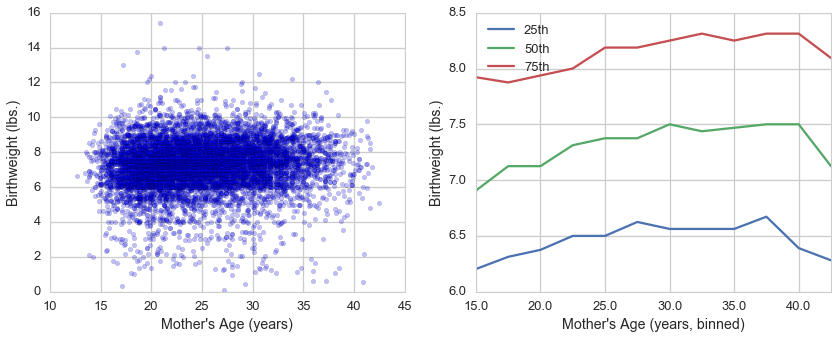

In [10]:
sns.set_context('talk')
sns.set_style('whitegrid')

fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_size_inches(14, 5)

df.plot('agepreg', 'totalwgt_lb', kind='scatter', color='blue', alpha=0.25, ax=ax1)
_ = ax1.set_xlabel('Mother\'s Age (years)')
_ = ax1.set_ylabel('Birthweight (lbs.)')
_ = ax1.set_ylim(0, 16)
_ = ax1.set_xlim(10, 45)

quantiles.drop(['size'], axis=1).plot(kind='line', ax=ax2)
_ = ax2.set_xlabel('Mother\'s Age (years, binned)')
_ = ax2.set_ylabel('Birthweight (lbs.)')